In [2]:
import boto3
from dotenv import dotenv_values
import pandas as pd
import re
import plotly.express as px
import matplotlib.pyplot as plt

config = dotenv_values(".env")
aws_access_key = config["AWS_ACCESS_KEY"]
aws_secret_access_key = config["AWS_SECRET_ACCESS_KEY"]

In [3]:

session = boto3.Session(aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_access_key)

In [4]:
def read_latest_csv(bucket_name, session = session):
    
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)

    # Get the list of objects in the bucket and sort them by date in descending order
    files = sorted(bucket.objects.all(),
                   key=lambda obj: obj.last_modified, reverse=True)

    # Find the first file with a valid date format in the name
    for file in files:
        file_name = file.key
        try:
            date_str = file_name.split('_')[1].split(
                '.')[0]  # Extract date from file name
            # Add more checks here if required to ensure the date format is valid
            obj = s3.Object(bucket_name, file_name)
            df = pd.read_csv(obj.get()['Body'])
            return df
        except IndexError:
            pass

    return None  # No valid files found


In [5]:
bucket_name = 'rafpang-airflow-youtube-bucket'
fcc_df = read_latest_csv(bucket_name)
fcc_df.head()


,Unnamed: 0,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs
0,0,BpPEoZW5IiY,freeCodeCamp.org,Learn Rust Programming - Complete Course 🦀,In this comprehensive Rust course for beginner...,NaN,2023-06-08 20:43:32,5127,693.0,NaN,0,PT13H59M10S,hd,False,0 days 13:59:10
1,1,IA3WxTTPXqQ,freeCodeCamp.org,Deep Learning for Computer Vision with Python ...,Learn the basics of computer vision with deep ...,NaN,2023-06-06 22:04:19,66881,3346.0,NaN,141,P1DT13H16M41S,hd,True,1 days 13:16:41
2,2,_IgbB24scLI,freeCodeCamp.org,Neo4j Course for Beginners,Learn how to use Neo4j with Java Spring Boot a...,NaN,2023-06-01 22:42:30,31402,894.0,NaN,44,PT5H24M59S,hd,True,0 days 05:24:59
3,3,jlogLBkPZ2A,freeCodeCamp.org,"Build AI Apps with ChatGPT, DALL-E, and GPT-4 ...",This course will teach you how to build AI-pow...,NaN,2023-05-30 23:14:01,74691,2512.0,NaN,84,PT4H34M58S,hd,True,0 days 04:34:58
4,4,GnodscC2p-A,freeCodeCamp.org,"Build and Deploy a LeetCode Clone with React, ...","In this project tutorial, you will build a Lee...",NaN,2023-05-25 22:33:36,53263,1837.0,NaN,74,PT7H10M,hd,False,0 days 07:10:00


### What is the most viewed Javascript framework tutorial?
React, Angular, Vue, or Svelte?

In [6]:
# Define the JavaScript frameworks you want to extract and their respective colors
framework_colors = {'React': 'rgb(0, 157, 255)', 'Vue': 'rgb(0, 204, 102)',
                    'Angular': 'rgb(255, 77, 77)', 'Svelte': 'rgb(255, 153, 51)'}

# Create a new column for the extracted JavaScript framework
fcc_df['javascript_framework'] = fcc_df['title'].str.extract(
    f"({'|'.join(framework_colors.keys())})", flags=re.IGNORECASE)

# Group the dataframe by the JavaScript framework column and calculate the sum of view counts
framework_view_counts = fcc_df.groupby('javascript_framework')[
    'viewCount'].sum().reset_index()

# Sort the dataframe by view count in descending order
framework_view_counts = framework_view_counts.sort_values(
    'viewCount', ascending=False)

# Create a bar chart using Plotly with color coding
fig = px.bar(framework_view_counts, x='javascript_framework', y='viewCount', color='javascript_framework',
             labels={'javascript_framework': 'JavaScript Framework',
                     'viewCount': 'View Count'},
             color_discrete_map=framework_colors)

# Update layout properties
fig.update_layout(
    title={
        'text': '<b>View Count per JavaScript Framework</b>',
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_tickangle=-45,
    font=dict(family='Arial, sans-serif'),
)

fig.show()

In [13]:
# Define the list of programming languages to search for
programming_languages = ['Python', 'JavaScript', 'Java', 'C\+\+', 'Ruby',]

# Create a new column for the extracted programming language
fcc_df['programming_language'] = fcc_df['title'].str.lower().str.extract(r'(' + '|'.join(map(str.lower, programming_languages)) + r')', flags=re.IGNORECASE)

# Group the dataframe by the programming language column and calculate the sum of viewCount
language_view_counts = fcc_df.groupby('programming_language')['viewCount'].sum().reset_index()

# Sort the dataframe by viewCount in descending order
language_view_counts = language_view_counts.sort_values('viewCount', ascending=False)

# Create a bar chart using Plotly
fig = px.bar(language_view_counts, x='programming_language', y='viewCount',
             labels={'programming_language': 'Programming Language', 'viewCount': 'View Count'},
             color='programming_language',
             color_discrete_sequence=px.colors.qualitative.Dark2)

# Update layout properties
fig.update_layout(
    title={
        'text': '<b>View Count per Programming Language</b>',
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_tickangle=-45,
    font=dict(family='Arial, sans-serif'),
)

fig.show()

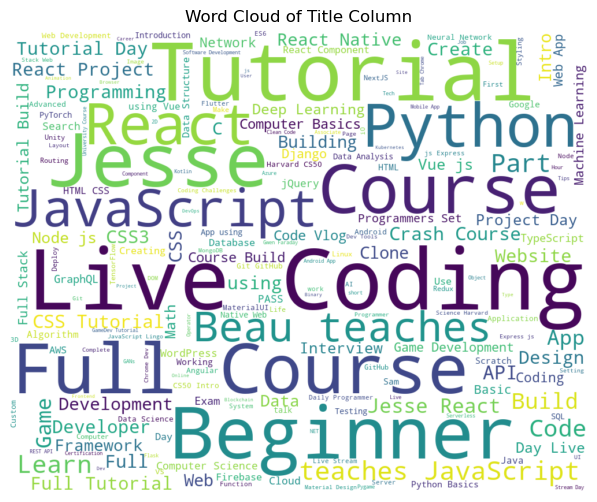

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Concatenate all the titles into a single string
titles_combined = ' '.join(fcc_df['title'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=800, background_color='white').generate(titles_combined)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Title Column')
plt.show()